# Dataset Selection and information

I chose to work with the **Bank Marketing dataset** from the UCI Machine Learning Repository.

- **Dataset link**: [https://archive.ics.uci.edu/dataset/222/bank+marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)
- **Instances**: 41,188
- **Features**: 20 (client demographics, campaign history, and contact attributes)
- **Target**: Binary classification  
  - `yes` = client subscribed to a term deposit  
  - `no` = client did not subscribe


## Data Preprocessing 

> Note: I have my own data preprocessing checklist which I used to guide data preprocessing.

### Peak Data to View Structure and Catagories

In [135]:
import pandas as pd

# Load the dataset 
# Note this data is semicolon sepperated
df = pd.read_csv('../data/raw/bank-additional-full.csv', sep=';')

# Peak the data so we can get an idea of how it looks
print(f"Shape: {df.shape}")
df.head()

# Check data types and nulls
df.info()
df.isnull().sum()

Shape: (41188, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.id

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Target Converting and Class balance 

In [136]:
# Convert target variable to binary classification
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Show updated class balance
print("Class distribution:")
print(df['y'].value_counts(normalize=True).round(3))

Class distribution:
y
0    0.887
1    0.113
Name: proportion, dtype: float64


### Encode Categorical and Normalize Numerical Data

In [137]:
from sklearn.preprocessing import StandardScaler

# Identify categorical and numeric features
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('y')

# One hot encode categoricals
# We want to drop the first column to ensure we dont have perfectly correleated columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True) # See reference [2]

# Standardize numeric columns
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

### Split and Save Data

In [138]:
# Imports
from sklearn.model_selection import train_test_split

# Split features and target
X = df.drop('y', axis=1)
y = df['y']

# Split data into 96% train, 4% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.04, stratify=y, random_state=42)

# Split temp data into 2% val, 2% test 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Save to cleaned data folder
X_train.to_csv('../data/cleaned/X_train.csv', index=False)
y_train.to_csv('../data/cleaned/y_train.csv', index=False)
X_val.to_csv('../data/cleaned/X_val.csv', index=False)
y_val.to_csv('../data/cleaned/y_val.csv', index=False)
X_test.to_csv('../data/cleaned/X_test.csv', index=False)
y_test.to_csv('../data/cleaned/y_test.csv', index=False)


# Nerual Net Manual Implementation

In [139]:
# Imports
import numpy as np

# Class to make simple 1 layer neural network 
class NeuralNetwork:
    # Initialize network structure 
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, seed=42):
        np.random.seed(seed)  
        self.learning_rate = learning_rate

        # Elected to use scaled random normal weight initalization (See reference [3])
        # Initialize weights and biases for hidden layer
        self.W1 = np.random.randn(input_size, hidden_size) * learning_rate
        self.b1 = np.zeros((1, hidden_size))

        # Initialize weights and biases for output layer
        self.W2 = np.random.randn(hidden_size, output_size) * learning_rate
        self.b2 = np.zeros((1, output_size))

    # Sigmoid activation
    def sigmoid(self, z):
        z = np.array(z, dtype=np.float64)  # Force z to be a compatable type solution from here: https://stackoverflow.com/questions/18557337/numpy-attributeerror-float-object-has-no-attribute-exp
        return 1 / (1 + np.exp(-z))

    # Derivative of sigmoid
    def sigmoid_derivative(self, a):
        return a * (1 - a)

    # Forward propagation
    def forward_propagation(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1 # input to hidden layer
        self.A1 = self.sigmoid(self.Z1) # activation of hidden layer
        self.Z2 = np.dot(self.A1, self.W2) + self.b2 # input to output layer
        self.A2 = self.sigmoid(self.Z2) # final prediction
        return self.A2

    # Compute binary cross entropy cost (This equation was derived in HIGGS linear classifiers)
    def compute_cost(self, Y_hat, Y):
        m = Y.shape[0]  # number of samples
        cost = -np.mean(Y * np.log(Y_hat + 1e-8) + (1 - Y) * np.log(1 - Y_hat + 1e-8))
        return cost

    # Backward propagation 
    def backward_propagation(self, X, Y, Y_hat):
        m = X.shape[0]

        # Gradient for output layer
        dZ2 = Y_hat - Y
        dW2 = (1 / m) * np.dot(self.A1.T, dZ2)
        db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True) # Note that we need keepdims here so the result keeps its (1 x output size) shape for compatibility with the bias

        # Gradient for hidden layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.sigmoid_derivative(self.A1)
        dW1 = (1 / m) * np.dot(X.T, dZ1)
        db1 = (1 / m) * np.sum(dZ1, axis=0, keepdims=True)

        # Update weights and biases VIA gradient descent (Where to implementearning rate from: https://www.geeksforgeeks.org/machine-learning/impact-of-learning-rate-on-a-model/)
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    # Training loop
    def train(self, X, Y, epochs=1000):
        for i in range(epochs):
            Y_hat = self.forward_propagation(X)
            cost = self.compute_cost(Y_hat, Y) 
            self.backward_propagation(X, Y, Y_hat)

    # Predict class labels from input
    def predict(self, X, threshold = 0.5):
        Y_hat = self.forward_propagation(X)
        return (Y_hat > threshold).astype(int) # Return array as same shape as Y_hat but with 1 for > treshold and 0 for < treshold


## Training Model

In [141]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load training and validation data
X_train = pd.read_csv('../data/cleaned/X_train.csv').astype(np.float64).values
y_train = pd.read_csv('../data/cleaned/y_train.csv').astype(np.float64).values.reshape(-1, 1)
X_val = pd.read_csv('../data/cleaned/X_val.csv').astype(np.float64).values
y_val = pd.read_csv('../data/cleaned/y_val.csv').astype(np.float64).values.reshape(-1, 1)

# Determine input size
input_size = X_train.shape[1]

# Initialize and train neural network
nn = NeuralNetwork(input_size=input_size, hidden_size=16, output_size=1, learning_rate=0.1)
nn.train(X_train, y_train, epochs=1000)

# Predict on validation data
y_val_pred = nn.predict(X_val)

# Evaluate metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9041
Precision: 0.6346
Recall: 0.3548
F1 Score: 0.4552


## Evaluation and Improving Classification Treshold

As we can see here the recall is very low which indicates the model is missing many true positives (This is expected with our inbalenced data set).     
Lets see if we can tune some hyperparameters to increase our preformance.

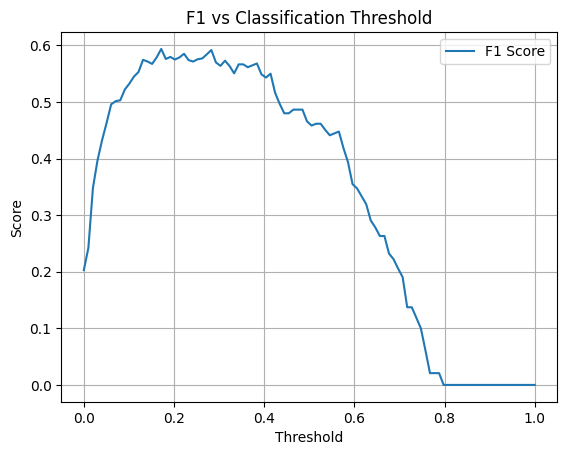

Best F1 Score: 0.5938 at Threshold: 0.17


In [153]:
# This idea was adapted from reference [4]
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict probabilities
Y_probs = nn.forward_propagation(X_val)

# Range of thresholds to test
thresholds = np.linspace(0.0, 1.0, 100)

# Store scores for each threshold
f1s = []

for t in thresholds:
    preds = (Y_probs > t).astype(int)
    f1s.append(f1_score(y_val, preds, zero_division=0))

# Plot F1 vs threshold
plt.plot(thresholds, f1s, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("F1 vs Classification Threshold")
plt.legend()
plt.grid(True)
plt.show()

best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Best F1 Score: {f1s[best_idx]:.4f} at Threshold: {best_threshold:.2f}")


## Reclassify with new Threshold

Now that we have a better threshold then our default 0.5, we will evaluate with a threshold of 0.17.

In [155]:
# Predict on validation data
y_val_pred = nn.predict(X_val, threshold = 0.17)

# Evaluate metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8726
Precision: 0.4639
Recall: 0.8280
F1 Score: 0.5946


## Testing Manual Neural Net Implementation

With a better recall lets test this on our sperate unseen test data 

Accuracy: 0.8968
Precision: 0.5299
Recall: 0.7634
F1 Score: 0.6256


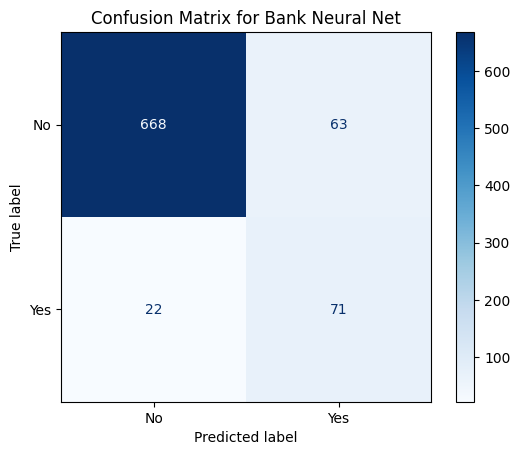

In [156]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load test data
X_test = pd.read_csv('../data/cleaned/X_test.csv').astype(np.float64).values
y_test = pd.read_csv('../data/cleaned/y_test.csv').astype(np.float64).values.reshape(-1, 1)

# Predict using threshold found in previous testing
y_test_pred = nn.predict(X_test, threshold=0.22)

# Evaluate 
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, zero_division=0)
recall = recall_score(y_test, y_test_pred, zero_division=0)
f1 = f1_score(y_test, y_test_pred, zero_division=0)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Bank Neural Net")
plt.show()


# Neural Network PyTorch Implementation

## Research into Pytorch Neural Networks

| Reference | Why I Used It |
|-----------|---------------|
| 5. https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html | Helped me understand how to define a neural network using `nn.Module`, structure layers, and implement the forward pass. |
| 6. https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html | Explained how PyTorch automatically handles backpropagation using `autograd`, replacing manual gradient calculations. |
| 7. https://pytorch.org/docs/stable/nn.html | Essential reference for understanding how to use layers, activation functions, loss functions, and optimizers. |


## Exploritory Data Analysis Extended

We included some minor Data Analysis in the first part durring the manual nerual network implementation, however, we will expand apon it in this section. We plan to: 
- Visualize the class imbalance in the target variable using a bar plot.  
- Analyze numeric feature relationships using a correlation heatmap 
- Explore categorical feature influence on subscription rates using bar plots.

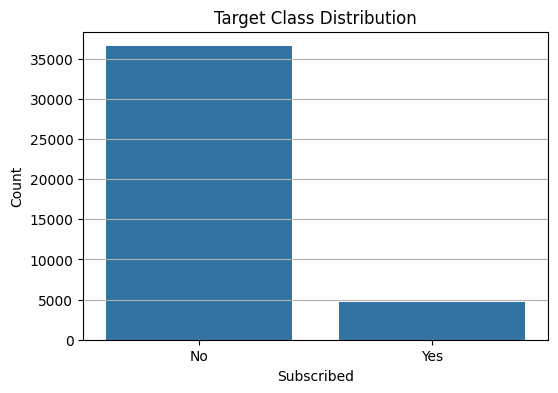

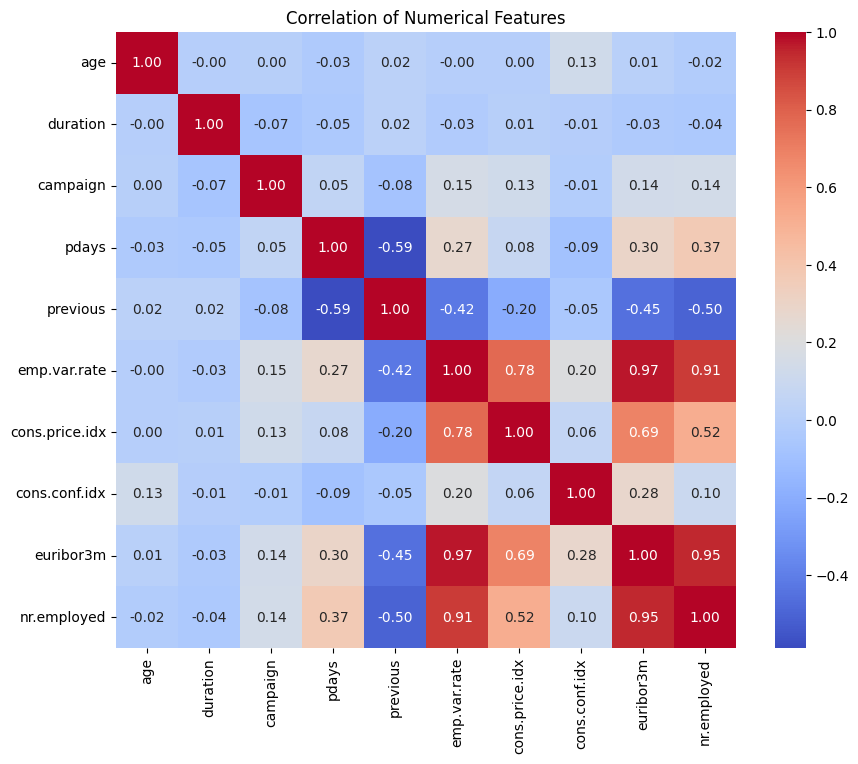

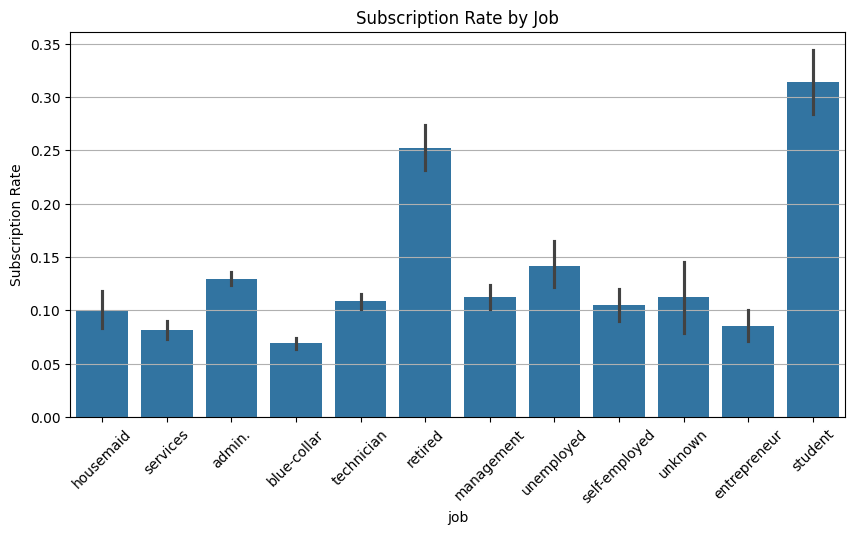

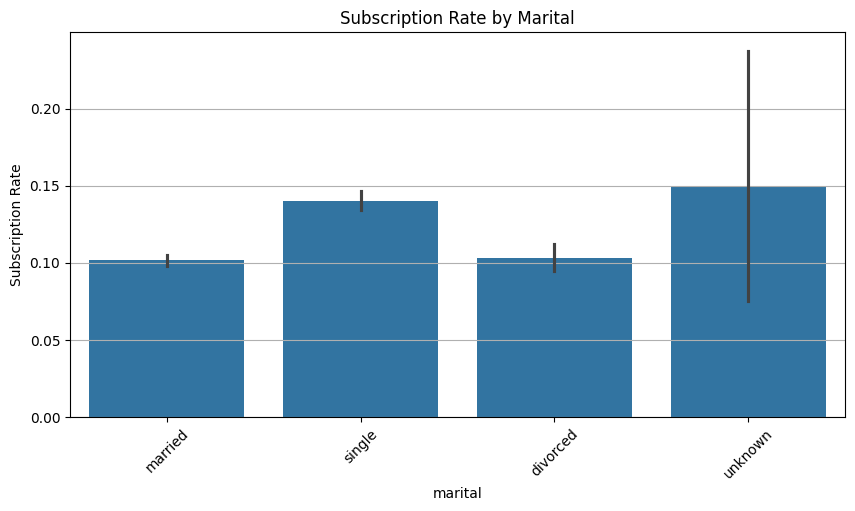

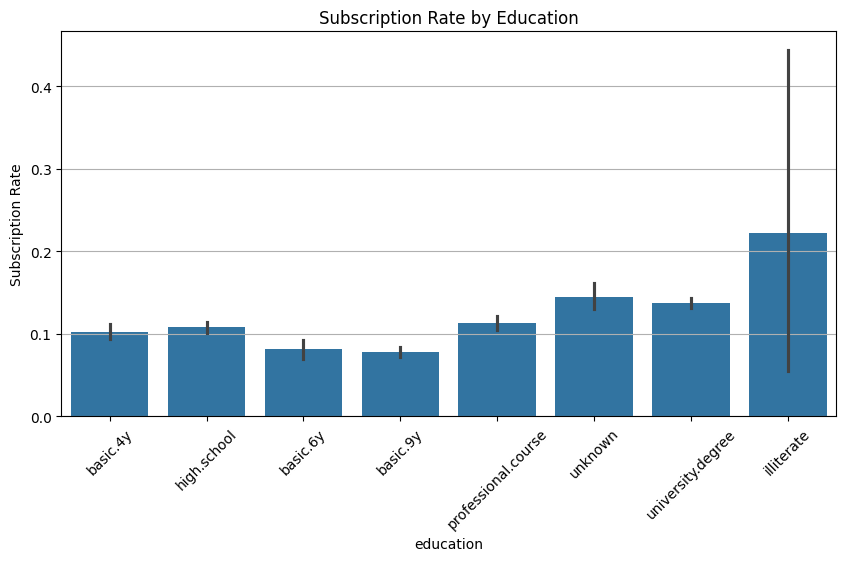

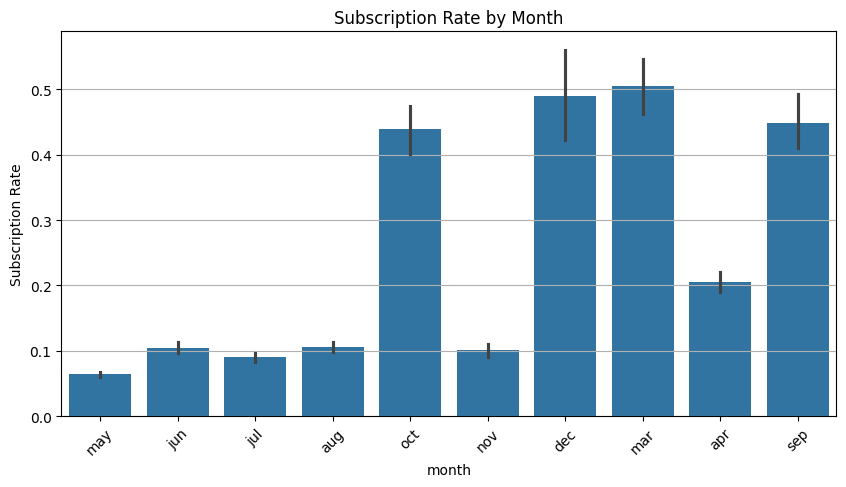

In [157]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='y')
plt.title("Target Class Distribution")
plt.xlabel("Subscribed")
plt.ylabel("Count")
plt.xticks([0,1], ['No', 'Yes'])
plt.grid(axis='y')
plt.show()

# Plot correlation heatmap for numerical features
plt.figure(figsize=(10,8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Numerical Features")
plt.show()

# Reload raw data for categorical feature analysis since we OHE the data previously
eda_df = pd.read_csv('../data/raw/bank-additional-full.csv', sep=';')
eda_df['y'] = eda_df['y'].map({'yes': 1, 'no': 0})

# Bar plots of select categorical features vs subscription rate
key_cat_features = ['job', 'marital', 'education', 'month']

for col in key_cat_features:
    plt.figure(figsize=(10,5))
    sns.barplot(x=col, y='y', data=eda_df, estimator='mean')
    plt.title(f"Subscription Rate by {col.title()}")
    plt.xticks(rotation=45)
    plt.ylabel("Subscription Rate")
    plt.grid(axis='y')
    plt.show()


## Model Implementation

> Note: We are using the train and test splits created durring our manual implementation

In [158]:
# Imports
import torch
import torch.nn as nn

# Define a 2 layer neural network with Pytorch
class Net(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # First layer
        self.relu = nn.ReLU() # ReLu Activation function
        self.fc2 = nn.Linear(hidden_size, 1) # Output layer
        self.sigmoid = nn.Sigmoid() # Sigmoid for binary output

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


## Model Training With Adams, RMSprop, and SGD (See reference [5] for general structure)

In [ ]:
# Imports
import torch
import torch.optim as optim
import pandas as pd
import numpy as np
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set consistent seed (see reference [8])
seed = 123
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Load training and validation data
X_train = pd.read_csv('../data/cleaned/X_train.csv').astype(np.float32).values
y_train = pd.read_csv('../data/cleaned/y_train.csv').astype(np.float32).values.reshape(-1, 1)
X_val = pd.read_csv('../data/cleaned/X_val.csv').astype(np.float32).values
y_val = pd.read_csv('../data/cleaned/y_val.csv').astype(np.float32).values.reshape(-1, 1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)

# Dictionary to store trained models
trained_models = {}

# Function to train and evaluate with a given optimizer
def train_with_optimizer(optimizer_name):
    torch.manual_seed(seed) 
    model = Net(input_size=X_train.shape[1], hidden_size=16)
    criterion = torch.nn.BCELoss()

    # Select optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.01)
    else:
        raise ValueError("Optimizer not available")

    for epoch in range(1000):
        # Set model to training mode
        model.train() 

        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor) 

        # Backward pass and optimization
        optimizer.zero_grad() # Clear previous gradients
        loss.backward() # Backpropagation
        optimizer.step() # Update model parameters

    # Save trained model
    trained_models[optimizer_name] = model

    # Evaluation
    model.eval()
    with torch.no_grad():
        val_probs = model(X_val_tensor)
        val_preds = (val_probs > 0.5).float().numpy()
        y_val_np = y_val_tensor.numpy()

    return {
        'Optimizer': optimizer_name,
        'Accuracy': accuracy_score(y_val_np, val_preds),
        'Precision': precision_score(y_val_np, val_preds),
        'Recall': recall_score(y_val_np, val_preds),
        'F1 Score': f1_score(y_val_np, val_preds),
    }

# Train with each optimizer and collect results
results = [train_with_optimizer(opt) for opt in ['Adam', 'SGD', 'RMSprop']]
results_df = pd.DataFrame(results)

# Display results
print(results_df)


  Optimizer  Accuracy  Precision    Recall  F1 Score
0      Adam  0.913835   0.644737  0.526882  0.579882
1       SGD  0.904126   0.612903  0.408602  0.490323
2   RMSprop  0.913835   0.657143  0.494624  0.564417


## Evaluation and Improving Classification Treshold for Adam Optimizer

As we can see the Adam optimizer slightly outpreformed RMS prop in terms of F1 score and recall while it fell behind in precision. Both exceded SGD in these fields. For this reason I will use classification threshold tuning for Adam's model.

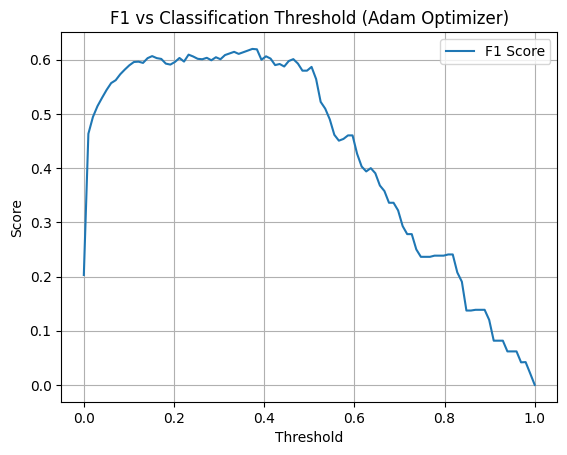

Best F1 Score: 0.6200 at Threshold: 0.37


In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Predict probabilities on validation set using Adam model
trained_models['Adam'].eval()
with torch.no_grad():
    val_probs = trained_models['Adam'](X_val_tensor).numpy()

# Generate a range of thresholds
thresholds = np.linspace(0.0, 1.0, 100)
f1s = []

# Evaluate F1 score at each threshold
for t in thresholds:
    preds = (val_probs > t).astype(int)
    f1s.append(f1_score(y_val, preds, zero_division=0))

# Plot F1 vs threshold
plt.plot(thresholds, f1s, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("F1 vs Classification Threshold (Adam Optimizer)")
plt.legend()
plt.grid(True)
plt.show()

# Report best threshold
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Best F1 Score: {f1s[best_idx]:.4f} at Threshold: {best_threshold:.2f}")


## Reclassify with new Threshold

Now that we have a better threshold then our default 0.5, we will evaluate with a threshold of 0.37.

In [181]:
# Predict Class
trained_models['Adam'].eval()
with torch.no_grad():
    val_probs = trained_models['Adam'](X_val_tensor)
    val_preds = (val_probs > 0.37).float().numpy()
    y_val_np = y_val_tensor.numpy()

# Evaluate Metrics
accuracy = accuracy_score(y_val_np, val_preds)
precision = precision_score(y_val_np, val_preds)
recall = recall_score(y_val_np, val_preds)
f1 = f1_score(y_val_np, val_preds)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9078
Precision: 0.5794
Recall: 0.6667
F1 Score: 0.6200


### Evaluation

As you can see there was some minor improvment but not much of a jump when commpared to our manual implementation's classification threshold tuning.

## Testing Pytorch Neural Net Implementation

Now lets test the model on completely unseen data

Accuracy: 0.9199
Precision: 0.6337
Recall: 0.6882
F1 Score: 0.6598


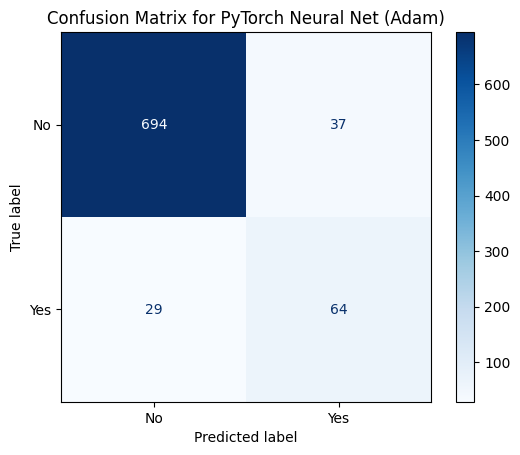

In [182]:
# Load test data
X_test = pd.read_csv('../data/cleaned/X_test.csv').astype(np.float32).values
y_test = pd.read_csv('../data/cleaned/y_test.csv').astype(np.float32).values.reshape(-1, 1)

# Convert to tensors
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

# Predict Class
with torch.no_grad():
    test_probs = trained_models['Adam'](X_test_tensor).numpy()
    test_preds = (test_probs > 0.37).astype(int) 
    y_test_np = y_test_tensor.numpy()

# Evaluate metrics
accuracy = accuracy_score(y_test_np, test_preds)
precision = precision_score(y_test_np, test_preds)
recall = recall_score(y_test_np, test_preds)
f1 = f1_score(y_test_np, test_preds)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test_np, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for PyTorch Neural Net (Adam)")
plt.show()

# Conclusions

When comparing an Adam optimized Pytorch model to our manual implementation, we can see the main difference is the manual implementation is less precise but has a better recall score whereas the Adam optimized model has a better precision at the ocst of recall. We selected hyperparameters through tuning based on validation F1 score. A hidden layer size of 16 and a learning rate of 0.01 were chosen to balance learning capacity and convergence stability. Hidden layers of size 8 and 32 performed worse across both models. We compared Adam, RMSprop, and SGD optimizers under the same conditions and selected Adam due to its performance. Classification threshold tuning was also performed to improve F1 score. I did not feel regularization was needed in this situation as the model showed no signs of overfitting.

## References

1. Moro, S., Cortez, P., & Rita, P. (2014). *A data-driven approach to predict the success of bank telemarketing*. Decision Support Systems, 62, 22–31.  
   Retrieved from https://archive.ics.uci.edu/dataset/222/bank+marketing

2. GeeksforGeeks. (n.d.). *One-hot encoding in machine learning*.  
   Retrieved from https://www.geeksforgeeks.org/machine-learning/ml-one-hot-encoding/

3. GeeksforGeeks. (n.d.). *Weight Initialization Techniques for Deep Neural Networks*.  
Retrieved from https://www.geeksforgeeks.org/machine-learning/weight-initialization-techniques-for-deep-neural-networks/

4. GeeksforGeeks. (n.d.). *Handling Imbalanced Data for Classification*.  
    Retrieved from https://www.geeksforgeeks.org/machine-learning/handling-imbalanced-data-for-classification/

5. PyTorch. (n.d.). *Neural Networks Tutorial*.  
   Retrieved from https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

6. PyTorch. (n.d.). *Autograd Tutorial*.  
   Retrieved from https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

7. PyTorch. (n.d.). *torch.nn — Modules Documentation*.  
   Retrieved from https://pytorch.org/docs/stable/nn.html

8. PyTorch. (n.d.). *torch.manual_seed*.  
   Retrieved from https://docs.pytorch.org/docs/stable/generated/torch.manual_seed.html
